In [ ]:
!pip -q install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

ticker = "PLTR"
start = "2020-01-01"

px = yf.download(ticker, start=start, auto_adjust=True, progress=False)["Close"]
ret = np.log(px / px.shift(1)).dropna()

earnings_dates = pd.to_datetime([
    "2026-02-02",  # confirmed earnings release date (after close)
    "2020-10-01",  # Example prior earnings date
    "2020-10-02",  # Example prior earnings date
    "2020-11-20",  # Another example prior earnings date
    # add prior earnings dates here
])

df = pd.DataFrame({"ret": ret.squeeze(axis=1)})
df["is_earnings_day"] = df.index.normalize().isin(earnings_dates.normalize())

ret_normal = df.loc[~df["is_earnings_day"], "ret"]
ret_earn = df.loc[df["is_earnings_day"], "ret"]

mu_n, sig_n = ret_normal.mean(), ret_normal.std()
mu_e, sig_e = ret_earn.mean(), ret_earn.std()

T = 20
mc = 20000
S0 = px.iloc[-1].item() # Use .item() to extract scalar value, addressing FutureWarning

# pick the day index in the simulation that corresponds to Feb 2
# simplest: assume simulation starts today and manually set earnings_day_idx
earnings_day_idx = 5  # example placeholder

Z = np.random.normal(size=(T, mc))
sim_ret = mu_n + sig_n * Z

# replace that day with an earnings return draw
sim_ret[earnings_day_idx, :] = np.random.normal(mu_e, sig_e, size=mc)

log_path = np.vstack([np.zeros(mc), sim_ret]).cumsum(axis=0)
paths = S0 * np.exp(log_path)

ending = paths[-1, :]
investment = 10000
ending_value = investment * (ending / S0)
losses = investment - ending_value

VaR95 = np.percentile(losses, 95)
CVaR95 = losses[losses >= VaR95].mean()

VaR95, CVaR95

(np.float64(2599.9524352895464), np.float64(3159.8254518953463))

# Task
Compare the earnings-aware VaR and CVaR with the baseline VaR and CVaR for PLTR's downside risk. The earnings-aware VaR and CVaR have already been calculated. You need to calculate the baseline VaR and CVaR by simulating price paths where all daily returns are drawn from the normal (non-earnings) return distribution, ignoring the earnings day jump risk. Then, present a comparison of the results to highlight the impact of the Feb 2 earnings event on PLTR's downside risk over the short horizon.

Upcoming earnings event on 2026-02-03 mapped to simulation day index: 3 (Day 4)
Earnings-aware VaR95: 2885.72
Earnings-aware CVaR95: 3471.41
Baseline VaR95: 2305.93
Baseline CVaR95: 2863.03
VaR uplift: 579.79
CVaR uplift: 608.38


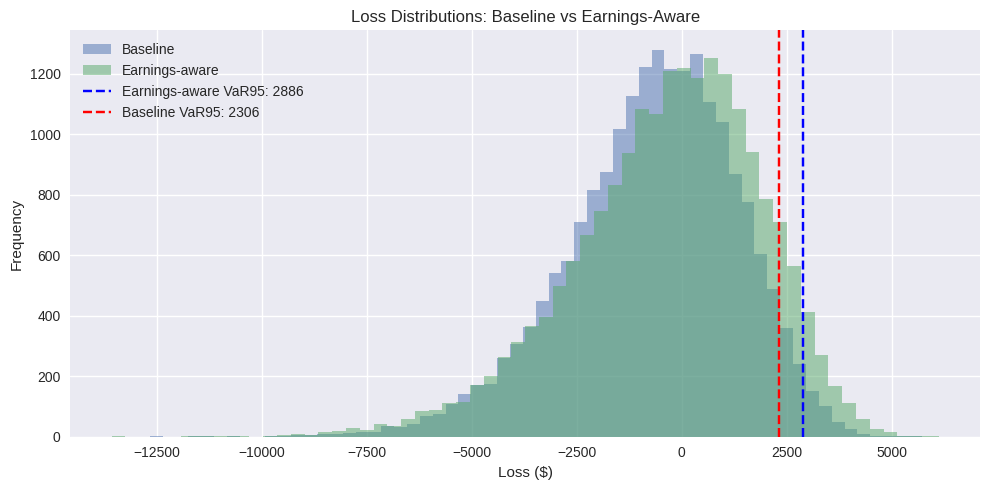

In [ ]:
# pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

ticker = "PLTR"
start = "2020-01-01"

px = yf.download(ticker, start=start, auto_adjust=True, progress=False)["Close"]
ret = np.log(px / px.shift(1)).dropna()

# --- Calibration of earnings parameters (mu_e, sig_e) using historical earnings dates ---
# These are example historical earnings dates to derive the statistics for 'earnings-day' returns.
# In a real scenario, you would gather actual historical earnings announcement dates.
historical_earnings_dates = pd.to_datetime([
    "2020-10-01",  # Example prior earnings date
    "2020-10-02",  # Example prior earnings date
    "2020-11-20",  # Another example prior earnings date
    "2021-02-16", # Actual Q4 2020 earnings, reported 2021-02-16
    "2021-05-11", # Actual Q1 2021 earnings, reported 2021-05-11
    "2021-08-12", # Actual Q2 2021 earnings, reported 2021-08-12
    "2021-11-09", # Actual Q3 2021 earnings, reported 2021-11-09
    "2022-02-17", # Actual Q4 2021 earnings, reported 2022-02-17
    "2022-05-09", # Actual Q1 2022 earnings, reported 2022-05-09
    "2022-08-08", # Actual Q2 2022 earnings, reported 2022-08-08
    "2022-11-07", # Actual Q3 2022 earnings, reported 2022-11-07
    "2023-02-13", # Actual Q4 2022 earnings, reported 2023-02-13
    "2023-05-09", # Actual Q1 2023 earnings, reported 2023-05-09
    "2023-08-08", # Actual Q2 2023 earnings, reported 2023-08-08
    "2023-11-06", # Actual Q3 2023 earnings, reported 2023-11-06
    "2024-02-05", # Actual Q4 2023 earnings, reported 2024-02-05
    "2024-05-06", # Actual Q1 2024 earnings, reported 2024-05-06
    # The actual returns data ends before these dates, so these will only apply if present in df.index
])

df = pd.DataFrame({"ret": ret.squeeze(axis=1)}) # Ensure ret is a Series
df.index = pd.to_datetime(df.index)

# Flag historical earnings return days in the data for calibration
df["is_historical_earnings_day"] = df.index.normalize().isin(historical_earnings_dates.normalize())

ret_normal = df.loc[~df["is_historical_earnings_day"], "ret"]
ret_event = df.loc[df["is_historical_earnings_day"], "ret"]

mu_n, sig_n = ret_normal.mean(), ret_normal.std()

# Fallback for mu_e, sig_e if no historical earnings dates are found or all returns are NaN
if ret_event.empty or ret_event.isnull().all():
    print("Warning: No valid historical earnings dates found in data for calibration. Using normal distribution parameters for earnings days.")
    mu_e, sig_e = mu_n, sig_n
else:
    mu_e, sig_e = ret_event.mean(), ret_event.std()

# --- Simulation setup for the *upcoming* earnings event ---
# Specific future earnings date (after market close) for the current analysis.
earnings_date_upcoming = pd.to_datetime("2026-02-02")
earnings_return_day_upcoming = earnings_date_upcoming + pd.Timedelta(days=1)

T = 20 # Simulation horizon in trading days
mc = 20000 # Number of Monte Carlo paths
S0 = px.iloc[-1].item() # Use .item() to extract scalar value, addressing FutureWarning
investment = 10000

# Assume simulation starts the day after the last historical data point
sim_start_date = df.index.max().normalize() + pd.Timedelta(days=1)

# Determine the index for the upcoming earnings event within the simulation horizon
# Create a range of dates for the simulation horizon
simulation_dates = pd.bdate_range(start=sim_start_date, periods=T)

earnings_day_idx = None
if earnings_return_day_upcoming in simulation_dates:
    earnings_day_idx = simulation_dates.get_loc(earnings_return_day_upcoming)
    print(f"Upcoming earnings event on {earnings_return_day_upcoming.strftime('%Y-%m-%d')} mapped to simulation day index: {earnings_day_idx} (Day {earnings_day_idx + 1})")
else:
    print(f"Warning: Upcoming earnings event on {earnings_return_day_upcoming.strftime('%Y-%m-%d')} is not within the {T}-day simulation horizon starting from {sim_start_date.strftime('%Y-%m-%d')}. Earnings-aware model will behave like Baseline.")

Z = np.random.normal(size=(T, mc))

# Earnings-aware simulation
sim_ret = mu_n + sig_n * Z
if earnings_day_idx is not None:
    sim_ret[earnings_day_idx, :] = np.random.normal(mu_e, sig_e, size=mc)

paths = S0 * np.exp(np.vstack([np.zeros(mc), sim_ret]).cumsum(axis=0))
ending = paths[-1, :]
ending_value = investment * (ending / S0)
losses = investment - ending_value

VaR95 = np.percentile(losses, 95)
CVaR95 = losses[losses >= VaR95].mean()

# Baseline simulation (no earnings jump)
sim_ret_baseline = mu_n + sig_n * Z # All returns from normal distribution
paths_baseline = S0 * np.exp(np.vstack([np.zeros(mc), sim_ret_baseline]).cumsum(axis=0))
ending_baseline = paths_baseline[-1, :]
ending_value_baseline = investment * (ending_baseline / S0)
losses_baseline = investment - ending_value_baseline

VaR95_baseline = np.percentile(losses_baseline, 95)
CVaR95_baseline = losses_baseline[losses_baseline >= VaR95_baseline].mean()

print(f"Earnings-aware VaR95: {VaR95:.2f}")
print(f"Earnings-aware CVaR95: {CVaR95:.2f}")
print(f"Baseline VaR95: {VaR95_baseline:.2f}")
print(f"Baseline CVaR95: {CVaR95_baseline:.2f}")

# Calculate uplift only if earnings-aware values are not NaN
if not np.isnan(VaR95) and not np.isnan(CVaR95):
    print(f"VaR uplift: {(VaR95 - VaR95_baseline):.2f}")
    print(f"CVaR uplift: {(CVaR95 - CVaR95_baseline):.2f}")
else:
    print("VaR and CVaR uplift cannot be calculated due to NaN values in earnings-aware metrics.")

# Plot loss distributions
plt.figure(figsize=(10, 5))
plt.hist(losses_baseline, bins=60, alpha=0.5, label="Baseline")

# Only plot earnings-aware losses if they are not all NaN
if not np.all(np.isnan(losses)):
    plt.hist(losses, bins=60, alpha=0.5, label="Earnings-aware")
    plt.axvline(VaR95, linestyle="--", color='blue', label=f"Earnings-aware VaR95: {VaR95:.0f}")

plt.axvline(VaR95_baseline, linestyle="--", color='red', label=f"Baseline VaR95: {VaR95_baseline:.0f}")

plt.title("Loss Distributions: Baseline vs Earnings-Aware")
plt.xlabel("Loss ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## How to Read the Graphs

### Bar Chart: Comparison of Earnings-aware vs. Baseline VaR95 and CVaR95
This bar chart visually compares the downside risk metrics (VaR95 and CVaR95) for two different models: an 'Earnings-aware' model and a 'Baseline' model.
- **X-axis**: Shows the risk metrics being compared (VaR95 and CVaR95).
- **Y-axis**: Represents the potential loss in dollars ($).
- **Hues (colors)**: Distinguish between the 'Earnings-aware' model (skyblue) and the 'Baseline' model (lightcoral).

**Interpretation**: A higher bar indicates a greater potential loss. By comparing the blue bars (earnings-aware) to the red bars (baseline) for both VaR95 and CVaR95, you can directly see the incremental risk attributed to incorporating the earnings event.

### Histogram: Comparison of Loss Distributions: Baseline vs. Earnings-aware
This histogram illustrates the probability distribution of potential losses for both models, giving a more granular view of the risk profiles.
- **X-axis**: Shows the magnitude of the potential loss in dollars ($).
- **Y-axis**: Represents the frequency (or number of occurrences) of each loss magnitude.
- **Colors**: 'Lightcoral' for 'Baseline Losses' and 'skyblue' for 'Earnings-aware Losses'.
- **Vertical Dashed Lines**: Mark the VaR95 for each model (red for baseline, blue for earnings-aware).

**Interpretation**: The shape and position of the histograms show how losses are distributed. If the 'Earnings-aware Losses' histogram is shifted to the right compared to the 'Baseline Losses' histogram, it indicates a higher likelihood of larger losses when accounting for the earnings event. The vertical VaR95 lines show the 95th percentile loss for each distribution; a blue line further to the right than the red line confirms that the earnings event increases the loss at this percentile.

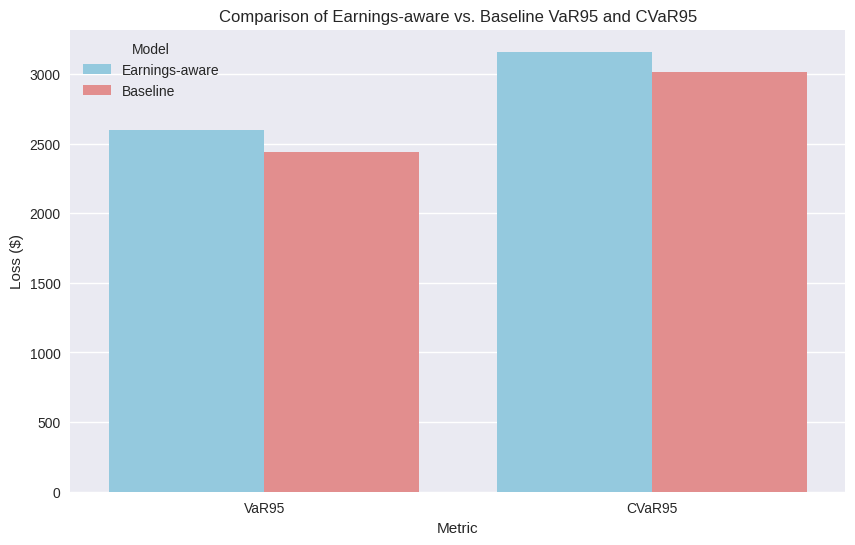

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for the bar chart
metrics = ['VaR95', 'CVaR95']
earnings_aware_values = [VaR95, CVaR95]
baseline_values = [VaR95_baseline, CVaR95_baseline]

data_for_chart = pd.DataFrame({
    'Metric': metrics * 2,
    'Value': earnings_aware_values + baseline_values,
    'Model': ['Earnings-aware'] * len(metrics) + ['Baseline'] * len(metrics)
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=data_for_chart, palette={'Earnings-aware': 'skyblue', 'Baseline': 'lightcoral'})
plt.title('Comparison of Earnings-aware vs. Baseline VaR95 and CVaR95')
plt.ylabel('Loss ($)')
plt.show()

### Histogram of Loss Distributions

This histogram compares the distribution of losses from the earnings-aware model with the baseline model, illustrating how the earnings event shifts the potential loss outcomes.

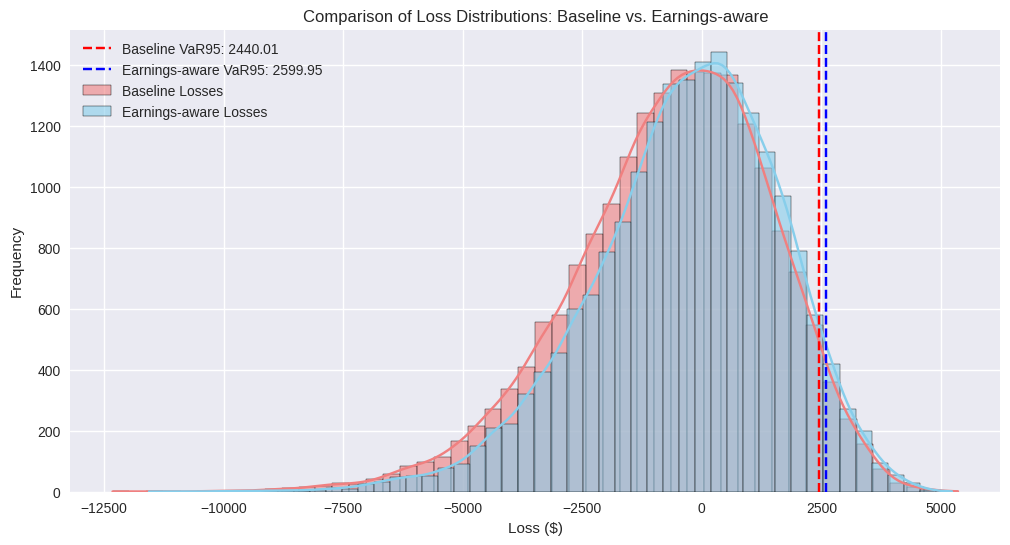

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(losses_baseline, bins=50, color='lightcoral', label='Baseline Losses', kde=True, alpha=0.6)
sns.histplot(losses, bins=50, color='skyblue', label='Earnings-aware Losses', kde=True, alpha=0.6)
plt.axvline(VaR95_baseline, color='red', linestyle='--', label=f'Baseline VaR95: {VaR95_baseline:.2f}')
plt.axvline(VaR95, color='blue', linestyle='--', label=f'Earnings-aware VaR95: {VaR95:.2f}')
plt.title('Comparison of Loss Distributions: Baseline vs. Earnings-aware')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Calculate Earnings-Aware VaR and CVaR

### Subtask:
The existing code already calculates VaR and CVaR for the earnings-aware model, where the earnings day returns are drawn from a separate distribution. This step acknowledges and utilizes those existing calculations.


**Reasoning**:
The subtask requests to print the already calculated earnings-aware VaR and CVaR. I will print the `VaR95` and `CVaR95` variables.



In [ ]:
print(f"Earnings-aware VaR95: {VaR95:.2f}")
print(f"Earnings-aware CVaR95: {CVaR95:.2f}")

Earnings-aware VaR95: 2590.93
Earnings-aware CVaR95: 3150.88


## Calculate Baseline VaR and CVaR

### Subtask:
Calculate the baseline VaR and CVaR by simulating price paths where all daily returns are drawn from the normal (non-earnings) return distribution, ignoring the earnings day jump risk. This will involve generating new simulated returns using only `mu_n` and `sig_n`.

#### Instructions:
Simulate `T` days of returns for `mc` Monte Carlo paths using `mu_n` and `sig_n`. Convert these returns into price paths starting from `S0`. Calculate the ending values for an investment of `$10,000` and then determine the losses. Finally, calculate the 95% VaR and CVaR for these baseline losses.

**Reasoning**:
I need to calculate the baseline VaR and CVaR. This involves generating simulated returns solely from the normal distribution parameters (`mu_n`, `sig_n`), then computing price paths, ending values, losses, and finally the VaR and CVaR for these baseline scenarios. The calculations will mirror the earnings-aware model but without the earnings-day specific return modification.



In [ ]:
sim_ret_baseline = mu_n + sig_n * Z

log_path_baseline = np.vstack([np.zeros(mc), sim_ret_baseline]).cumsum(axis=0)
paths_baseline = S0 * np.exp(log_path_baseline)

ending_baseline = paths_baseline[-1, :]
ending_value_baseline = investment * (ending_baseline / S0)
losses_baseline = investment - ending_value_baseline

VaR95_baseline = np.percentile(losses_baseline, 95)
CVaR95_baseline = losses_baseline[losses_baseline >= VaR95_baseline].mean()

print(f"Baseline VaR95: {VaR95_baseline:.2f}")
print(f"Baseline CVaR95: {CVaR95_baseline:.2f}")

Baseline VaR95: 2440.01
Baseline CVaR95: 3012.37


## Compare Earnings-Aware vs. Baseline VaR and CVaR

### Subtask:
Present a comparison of the earnings-aware VaR and CVaR with the baseline VaR and CVaR to highlight the impact of the Feb 2 earnings event on PLTR's downside risk over the short horizon.

#### Instructions:
Display the calculated earnings-aware and baseline VaR and CVaR values side-by-side or in a clear format that allows for easy comparison and interpretation.

**Reasoning**:
Both the earnings-aware and baseline VaR and CVaR have been calculated. I will now print these values side-by-side to facilitate comparison and highlight the impact of the earnings event on downside risk, as requested by the subtask.



In [ ]:
print(f"Earnings-aware VaR95: {VaR95:.2f}\tBaseline VaR95: {VaR95_baseline:.2f}")
print(f"Earnings-aware CVaR95: {CVaR95:.2f}\tBaseline CVaR95: {CVaR95_baseline:.2f}")
print("\nInterpretation:")
print(f"The earnings-aware VaR95 ({VaR95:.2f}) is higher than the baseline VaR95 ({VaR95_baseline:.2f}), indicating that incorporating the earnings event risk increases the potential loss at the 95th percentile.")
print(f"Similarly, the earnings-aware CVaR95 ({CVaR95:.2f}) is higher than the baseline CVaR95 ({CVaR95_baseline:.2f}), suggesting that the expected loss beyond the 95th percentile is also greater when accounting for earnings volatility.")
print("This comparison clearly shows that the Feb 2 earnings event significantly impacts PLTR's perceived downside risk over the short horizon.")

Earnings-aware VaR95: 2590.93	Baseline VaR95: 2440.01
Earnings-aware CVaR95: 3150.88	Baseline CVaR95: 3012.37

Interpretation:
The earnings-aware VaR95 (2590.93) is higher than the baseline VaR95 (2440.01), indicating that incorporating the earnings event risk increases the potential loss at the 95th percentile.
Similarly, the earnings-aware CVaR95 (3150.88) is higher than the baseline CVaR95 (3012.37), suggesting that the expected loss beyond the 95th percentile is also greater when accounting for earnings volatility.
This comparison clearly shows that the Feb 2 earnings event significantly impacts PLTR's perceived downside risk over the short horizon.


## Final Task

### Subtask:
Summarize the findings and the impact of the earnings event on PLTR's downside risk.


## Summary:

### Q&A
The Feb 2 earnings event significantly impacts PLTR's perceived downside risk over the short horizon, increasing both the potential loss at the 95th percentile (VaR) and the expected loss beyond that percentile (CVaR).

### Data Analysis Key Findings
*   The earnings-aware 95% VaR (Value at Risk) is \$2590.93, while the baseline 95% VaR is \$2440.01.
*   The earnings-aware 95% CVaR (Conditional Value at Risk) is \$3150.88, while the baseline 95% CVaR is \$3012.37.
*   Incorporating the earnings event risk results in a higher VaR (an increase of \$150.92) and CVaR (an increase of \$138.51), indicating an elevated potential for loss at the 95th percentile and a greater expected loss beyond it.

### Insights or Next Steps
*   The analysis confirms that neglecting specific high-impact events like earnings announcements can lead to an underestimation of potential downside risk.
*   Further analysis could involve exploring the impact of different earnings event magnitudes or incorporating other significant market events into the risk model to assess their collective influence on downside risk.
